In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve, auc, ndcg_score
from tdescore.classifier.train import train_classifier
from tdescore.classifier.features import host_columns, early_columns, peak_columns, post_peak, parse_columns
from tdescore.classifier.collate import get_classified_sources, convert_to_train_dataset, get_all_sources
import matplotlib.patheffects as path_effects
import pandas as pd
from pathlib import Path
import shap
from tdescore.classifier.collate import convert_to_train_dataset
import joblib

In [2]:
logging.getLogger("tdescore").setLevel("INFO")

In [3]:
all_features = [host_columns, early_columns, peak_columns, post_peak]

In [4]:
relevant_columns, column_descriptions = parse_columns(all_features[-1])
full_columns, full_descriptions = parse_columns(post_peak)

In [ ]:
all_sources = get_classified_sources(False)
data_to_use = convert_to_train_dataset(all_sources, columns=full_columns)
nan_mask = np.array([np.sum(np.isnan(x)) > 0 for x in data_to_use])
full_info_sources = all_sources[~nan_mask].reset_index(drop=True)
full_info_sources

In [6]:
df_to_use = full_info_sources

In [7]:
n_iter = 10
n_estimator_set = [75., 100., 125., 150., 175.]
n_estimator_set = [100.]

all_all_res, clfs = train_classifier(
    train_sources=df_to_use,
    n_iter=n_iter,
    columns=relevant_columns,
    n_estimator_set=n_estimator_set
)

n_estimator_set = list(sorted(clfs.keys()))

INFO:tdescore.classifier.train:Model is XGBClassifier
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:38<00:00,  9.85s/it]
INFO:tdescore.classifier.train:N estimators = 100
INFO:tdescore.classifier.train:Global score 99.23
INFO:tdescore.classifier.train:Global balanced score 88.39
INFO:tdescore.classifier.train:Global recovery fraction 77.1%
INFO:tdescore.classifier.train:Global purity 83.3%
INFO:tdescore.classifier.train:Global roc area 99.50
INFO:tdescore.classifier.train:Global precision/recall area 89.69


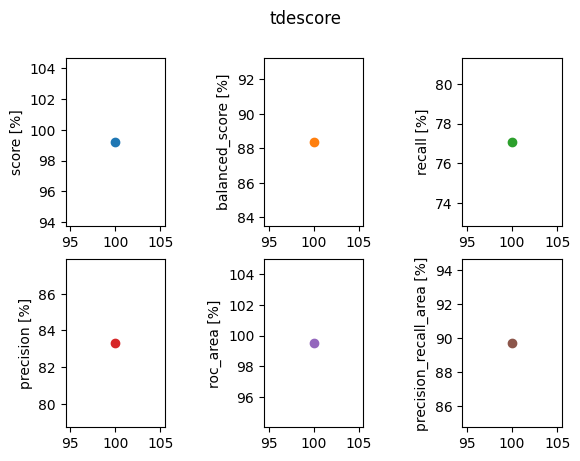

In [8]:
plt.figure()
plt.suptitle("tdescore")
c_metrics = [x for x in all_all_res.columns if x not in ["n_estimator", "all_res"]]
for i, y in enumerate(c_metrics):
    plt.subplot(2, 3, i+1)
    plt.plot(all_all_res["n_estimator"], all_all_res[y]*100., color=f"C{i}")
    plt.scatter(n_estimator_set, all_all_res[y]*100., color=f"C{i}")
    plt.ylabel(f'{y} [%]')

plt.subplots_adjust(wspace=1.0)
plt.show()

In [9]:
metric = "precision_recall_area"

best_index = all_all_res[metric].idxmax()

best_estimator = all_all_res.iloc[best_index]["n_estimator"]

print(f"Best value is {best_estimator}")

clf = clfs[best_estimator]
all_res = all_all_res[all_all_res["n_estimator"] == best_estimator]["all_res"].iloc[0]

Best value is 100.0


In [ ]:
all_res[all_res["class"]].sort_values(by="probs_0")

In [11]:
# output_path = Path.home().joinpath("tdescore.pkl")
# joblib.dump(clf, output_path)

In [12]:
def flatten():
    true_class = []
    all_probs = []
    for i in range(n_iter):
        probs = all_res[f"probs_{i}"]
        true_class += all_res[f"class"].tolist()
        all_probs += probs.tolist()
    return true_class, all_probs

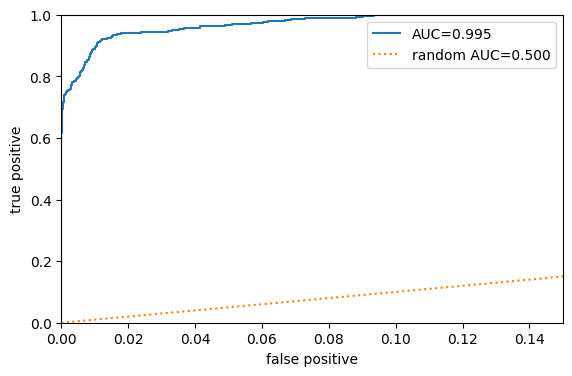

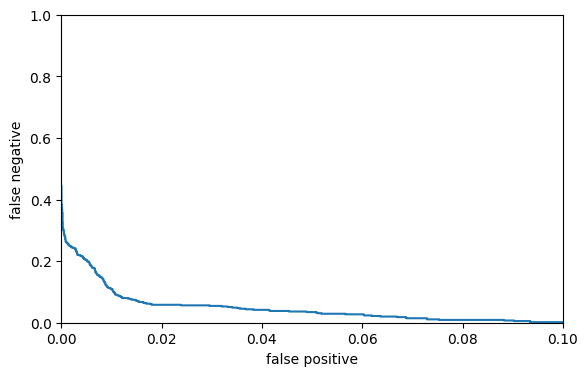

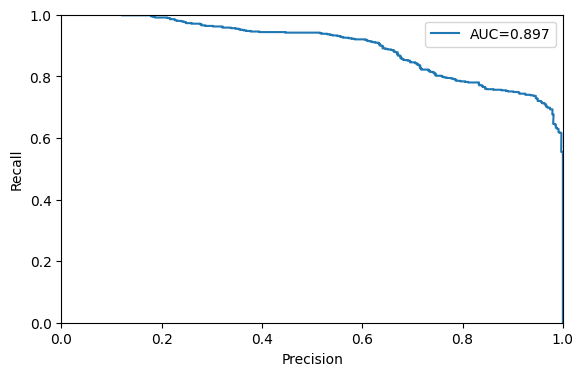

In [13]:
tclass, aprobs = flatten()

fscale = 4.
figsize=(fscale*1.618, fscale)

fpr, tpr, thresholds = metrics.roc_curve(tclass, aprobs)
plt.figure(figsize=figsize)
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(tclass, aprobs):.3f}")
plt.plot([0.0, 1.0], [0.0, 1.0], linestyle=":", label="random AUC=0.500")
plt.xlabel("false positive")
plt.ylabel("true positive")
plt.legend()
plt.xlim(0.0, 0.15)
plt.ylim(0.0, 1.0)
plt.savefig("figures/roc.pdf", bbox_inches='tight')
plt.show()

fpr, fnr, thresholds = metrics.det_curve(tclass, aprobs)
plt.figure(figsize=figsize)
plt.plot(fpr, fnr)
plt.xlabel("false positive")
plt.ylabel("false negative")
plt.xlim(0.0, 0.1)
plt.ylim(0.0, 1.0)
plt.savefig("figures/fp_fn.pdf", bbox_inches='tight')
plt.show()

x, y, thresholds = metrics.precision_recall_curve(tclass, aprobs)
plt.figure(figsize=figsize)
plt.plot(x, y, label=f"AUC={auc(y, x):.3f}")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.legend()
plt.savefig("figures/precision_recall.pdf", bbox_inches='tight')
plt.show()

In [14]:
pr, recall, thresholds = metrics.precision_recall_curve(tclass, aprobs)

index = np.arange(len(thresholds))

mask = recall[1:] >= 0.945

loose_index = max(index[mask])

threshold_loose = thresholds[loose_index]
print(f"Loose threshold {threshold_loose:.2f}, Precision={100.*pr[loose_index]:.1f}%, Recall={100.*recall[loose_index]:.1f}%")


mask = pr[:-1] >= 0.95
strict_index = min(index[mask])

threshold_strict = thresholds[strict_index]
print(f"Strict Threshold {threshold_strict:.2f}, Precision={100.*pr[strict_index]:.1f}%, Recall={100.*recall[strict_index]:.1f}%")

mask = pr[:-1] >= 0.8

balanced_index = min(index[mask])

threshold_balanced = thresholds[balanced_index]
print(f"Balanced Threshold {threshold_balanced:.2f}, Precision={100.*pr[balanced_index]:.1f}%, Recall={100.*recall[balanced_index]:.1f}%")

Loose threshold 0.01, Precision=39.5%, Recall=94.5%
Strict Threshold 0.91, Precision=95.0%, Recall=72.7%
Balanced Threshold 0.40, Precision=80.1%, Recall=78.4%


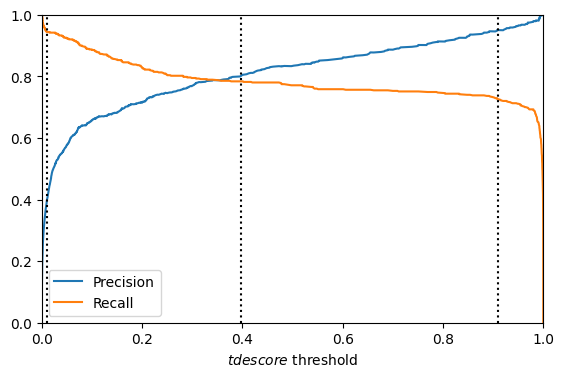

In [15]:
plt.figure(figsize=figsize)
plt.plot(thresholds[:-1], x[1:-1], label="Precision")
plt.plot(thresholds[:-1], y[1:-1], label="Recall")
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel(r"$\it{tdescore}$ threshold")
plt.legend()
for cut in [threshold_loose, threshold_balanced, threshold_strict]:
    plt.axvline(cut, linestyle=":", color="k")
plt.savefig("figures/precision_recall.pdf", bbox_inches='tight')
plt.show()

In [16]:
def plot_matrix(cut, label):
    print(f"Cut of {cut:.3f}")

    base_cm = confusion_matrix(tclass, np.array(aprobs) > cut)

    for k in range(2):
        
        plt.figure()
        
        if k==0:
            cm = base_cm/np.sum(base_cm, axis=0)
        elif k==1:
            cm = (base_cm.T/np.sum(base_cm, axis=1)).T
        else:
            cm = base_cm

        fig, ax = plt.subplots(figsize=(5, 4))
        ax.imshow(cm, cmap=plt.cm.Blues)
        ax.set_title(f'{["Prediction-Normalised", "Truth-Normalised", ""][k]} Confusion Matrix ({label})')
        ax.set_xticks(np.arange(len(cm)))
        ax.set_yticks(np.arange(len(cm)))
        ax.set_xticklabels(['Non-TDE', "TDE"])
        ax.set_yticklabels(['Non-TDE', "TDE"])
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('True label')
        for i in range(len(cm)):
            for j in range(len(cm)):
                ax.text(j, i, f"{100.*cm[i, j]:.1f}%\n\n({base_cm[i, j]/n_iter})", ha='center', va='center', color='white', fontsize=15,
                        path_effects=[path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()]
                       )        
        path = f"figures/matrix_{label}_{k}.pdf"
        plt.savefig(path)

Cut of 0.010


<Figure size 640x480 with 0 Axes>

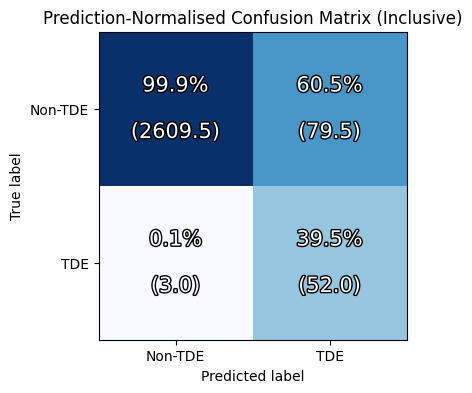

<Figure size 640x480 with 0 Axes>

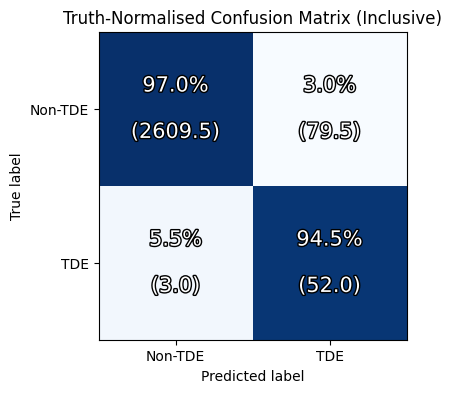

Cut of 0.398


<Figure size 640x480 with 0 Axes>

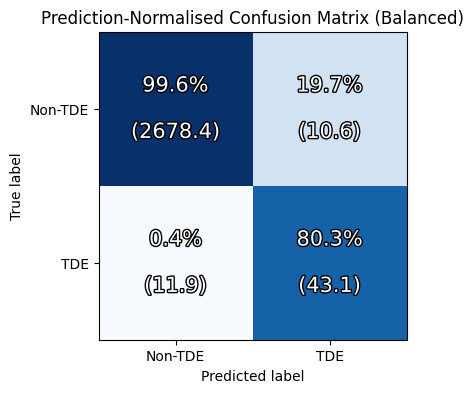

<Figure size 640x480 with 0 Axes>

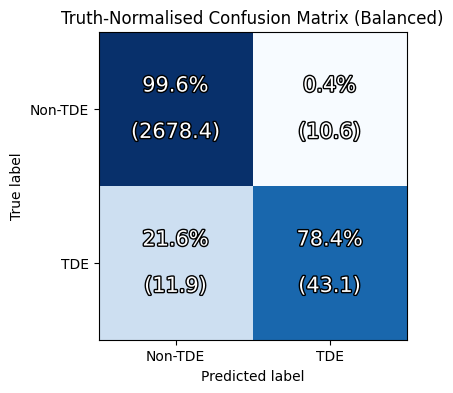

Cut of 0.911


<Figure size 640x480 with 0 Axes>

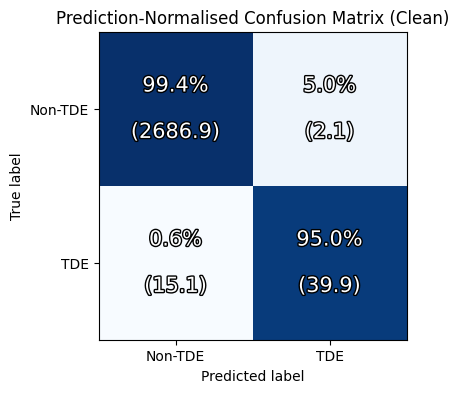

<Figure size 640x480 with 0 Axes>

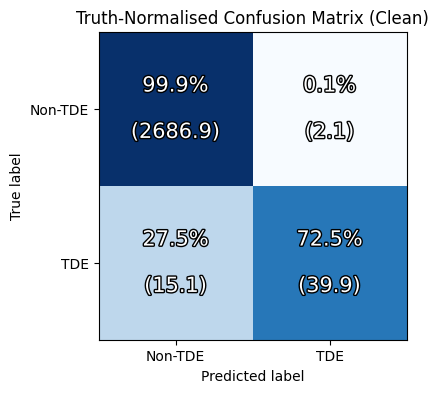

In [17]:
for i, cut in enumerate([threshold_loose, threshold_balanced, threshold_strict]):
    plot_matrix(cut, label=["Inclusive", "Balanced", "Clean"][i])
    plt.show()

In [18]:
features = pd.DataFrame([relevant_columns, column_descriptions, list(clf.feature_importances_), ]).T
features.sort_values(by=2, ascending=False, inplace=True)
features

,0,1,2
1,w1_m_w2,WISE W1$-$W2 host colour,0.323986
13,peak_color,Colour at g-band peak,0.160344
4,has_milliquas,Has milliquas crossmatch?,0.092582
18,color_grad,Rate of colour change,0.078266
23,sncosmo_chisq,sncosmo $\chi^{2}$,0.058784
26,sncosmo_c,sncosmo c parameter,0.046118
19,fade,Fade from G.P.,0.038285
16,det_cadence,Mean detection candence,0.024376
14,pre_inflection,Number of pre-peak inflections,0.022936
9,distpsnr1,Distance to PS1 host,0.018295


In [19]:
n_feature = len(relevant_columns)

text_str = r"""\begin{table*}[]
\centering
    \begin{tabular}{c|c|c}
    \textbf{Feature} &\textbf{Description}& \textbf{Importance (\%)}\\
    \hline
"""
print(text_str)
for _, row in features.iterrows():
    name = row[0].replace('_', '\_')
    print(f"\t{name} & {row[1]} & {100.*row[2]:.1f} \\\\")
print(r"\end{tabular}")
print(r"\caption{Relative importance of all " + str(len(features)) + r" features in \tdes, calculated by \xgboost \citep{xgboost} using the standard averaging of importance across all decision trees in the final model \citep[see e.g][]{ml_textbook}.}")
print(r"""\label{tab:importance}
\end{table*}""")

\begin{table*}[]
\centering
    \begin{tabular}{c|c|c}
    \textbf{Feature} &\textbf{Description}& \textbf{Importance (\%)}\\
    \hline

	w1\_m\_w2 & WISE W1$-$W2 host colour & 32.4 \\
	peak\_color & Colour at g-band peak & 16.0 \\
	has\_milliquas & Has milliquas crossmatch? & 9.3 \\
	color\_grad & Rate of colour change & 7.8 \\
	sncosmo\_chisq & sncosmo $\chi^{2}$ & 5.9 \\
	sncosmo\_c & sncosmo c parameter & 4.6 \\
	fade & Fade from G.P. & 3.8 \\
	det\_cadence & Mean detection candence & 2.4 \\
	pre\_inflection & Number of pre-peak inflections & 2.3 \\
	distpsnr1 & Distance to PS1 host & 1.8 \\
	length\_scale & Length scale from G.P. & 1.6 \\
	y\_scale & Y Scale from G.P. & 1.6 \\
	sncosmo\_x1 & sncosmo X1 parameter & 1.6 \\
	w3\_m\_w4 & WISE W3$-$W4 host colour & 1.2 \\
	post\_inflection & Number of post-peak inflections & 1.0 \\
	g-r\_MeanPSFMag & PS1 host $g-r$ colour & 0.9 \\
	sumrat & `Sum ratio' & 0.9 \\
	score & Score from G.P & 0.8 \\
	classtar & \texttt{SourceExtractor} vari

In [20]:
all_sources = get_all_sources()
data_to_use = convert_to_train_dataset(all_sources, columns=full_columns)

explainer = shap.Explainer(clf, data_to_use, feature_names=relevant_columns)
shap_values = explainer(data_to_use)

def explain(name, classification=None):
    fig = plt.figure()
    index = all_sources["ztf_name"].tolist().index(name)

    shap.plots.waterfall(
        shap_values[index],
        max_display=5, show=False
    )
    
    if classification is not None:
        title = f"{name} ({classification})"
    else:
        title = name
    
    plt.title(title)
    plt.show()
    return fig

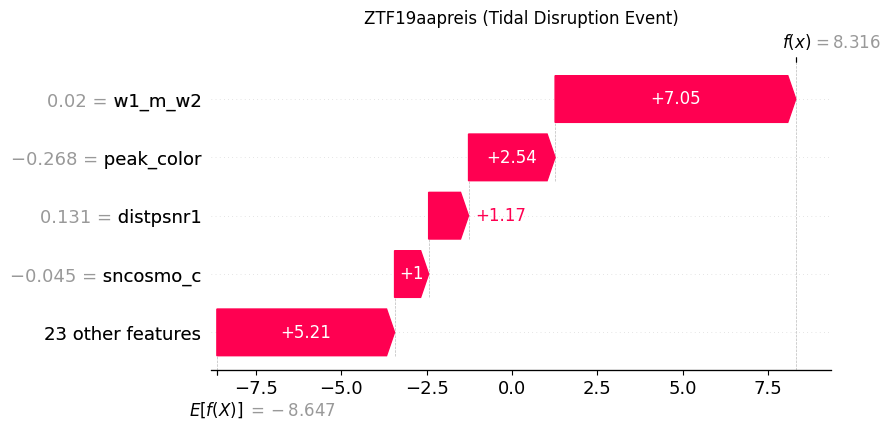

In [21]:
fig = explain("ZTF19aapreis", "Tidal Disruption Event")
fig.savefig("figures/ZTF19aapreis.pdf", bbox_inches='tight')

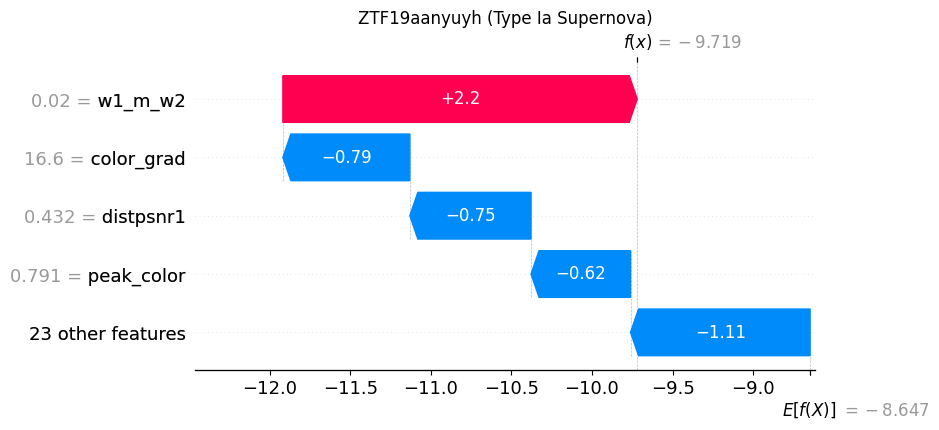

In [22]:
fig = explain("ZTF19aanyuyh", "Type Ia Supernova")
fig.savefig("figures/ZTF19aanyuyh.pdf", bbox_inches='tight')

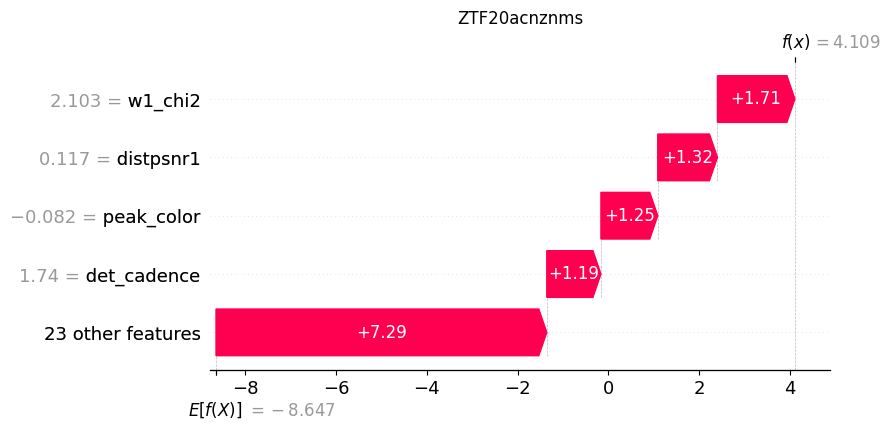

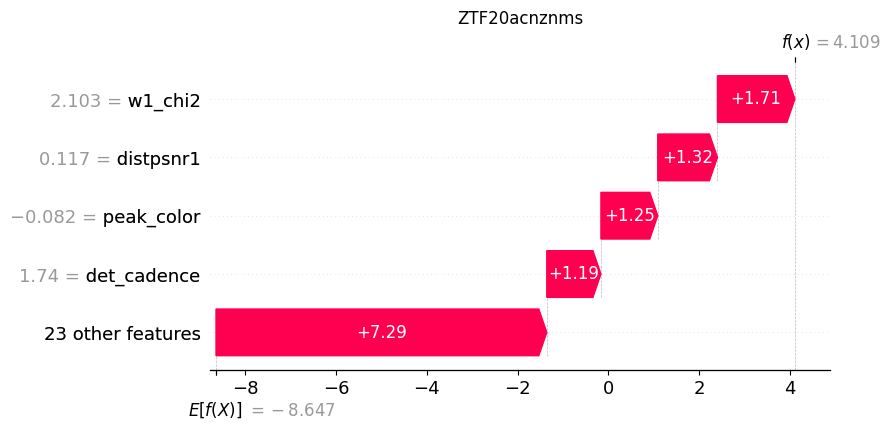

In [23]:
# explain("ZTF20acnznms")